In [3]:
# -------------------------------
# 1. Baca dan parsing file .arff
# -------------------------------
import arff
import pandas as pd

# Load dataset
with open('chronic_kidney_disease_full.arff') as f:
    data = arff.load(f)

df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])
df.head()


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1,0,None,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4,0,None,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2,3,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4,0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2,0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [4]:
# -------------------------------
# 2. Simulasi Missing Value
# -------------------------------
import numpy as np

# Daftar kolom numerik (yang akan disimulasikan missing)
numerics = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']

# Hilangkan 15% data dari tiap kolom numerik
missing_fraction = 0.15
np.random.seed(42)

for col in numerics:
    n = int(len(df) * missing_fraction)
    missing_idx = np.random.choice(df.index, n, replace=False)
    df.loc[missing_idx, col] = np.nan

# Cek hasil simulasi
print("Jumlah missing value per kolom:")
print(df[numerics].isna().sum())


Jumlah missing value per kolom:
age      67
bp       69
bgr     100
bu       75
sc       74
sod     133
pot     136
hemo    104
pcv     121
wbcc    146
rbcc    171
dtype: int64


In [5]:
# -------------------------------
# 3. Preprocessing
# -------------------------------
from sklearn.preprocessing import LabelEncoder

# Ubah kolom numerik jadi float & isi NaN dengan mean
for col in numerics:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].mean())

# Kategorikal (selain numerik & class)
categoricals = list(set(df.columns) - set(numerics) - {'class'})
for col in categoricals:
    df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode label class manual
label_map = {'ckd': 0, 'notckd': 1}
df['class'] = df['class'].map(label_map)

print("Preprocessing selesai:", df.shape)


Preprocessing selesai: (400, 25)


In [6]:
# -------------------------------
# 4. Split & Normalisasi
# -------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pisahkan fitur dan label
X = df.drop('class', axis=1)
y = df['class']

# Bagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
# -------------------------------
# 5. SVM Linear
# -------------------------------
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model SVM Linear
model_linear = SVC(kernel='linear', C=1.0)
model_linear.fit(X_train, y_train)

# Evaluasi
y_pred_linear = model_linear.predict(X_test)
print("📊 Classification Report (SVM Linear):")
print(classification_report(y_test, y_pred_linear, target_names=['ckd', 'notckd']))
print("🧮 Confusion Matrix (SVM Linear):")
print(confusion_matrix(y_test, y_pred_linear))
print(f"✅ Akurasi SVM Linear: {accuracy_score(y_test, y_pred_linear)*100:.2f}%")


📊 Classification Report (SVM Linear):
              precision    recall  f1-score   support

         ckd       1.00      1.00      1.00        52
      notckd       1.00      1.00      1.00        28

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

🧮 Confusion Matrix (SVM Linear):
[[52  0]
 [ 0 28]]
✅ Akurasi SVM Linear: 100.00%


In [8]:
# -------------------------------
# 6. SVM RBF
# -------------------------------
# Model SVM RBF
model_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
model_rbf.fit(X_train, y_train)

# Evaluasi
y_pred_rbf = model_rbf.predict(X_test)
print("📊 Classification Report (SVM RBF):")
print(classification_report(y_test, y_pred_rbf, target_names=['ckd', 'notckd']))
print("🧮 Confusion Matrix (SVM RBF):")
print(confusion_matrix(y_test, y_pred_rbf))
print(f"🔹 Akurasi SVM RBF: {accuracy_score(y_test, y_pred_rbf)*100:.2f}%")


📊 Classification Report (SVM RBF):
              precision    recall  f1-score   support

         ckd       1.00      0.98      0.99        52
      notckd       0.97      1.00      0.98        28

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

🧮 Confusion Matrix (SVM RBF):
[[51  1]
 [ 0 28]]
🔹 Akurasi SVM RBF: 98.75%


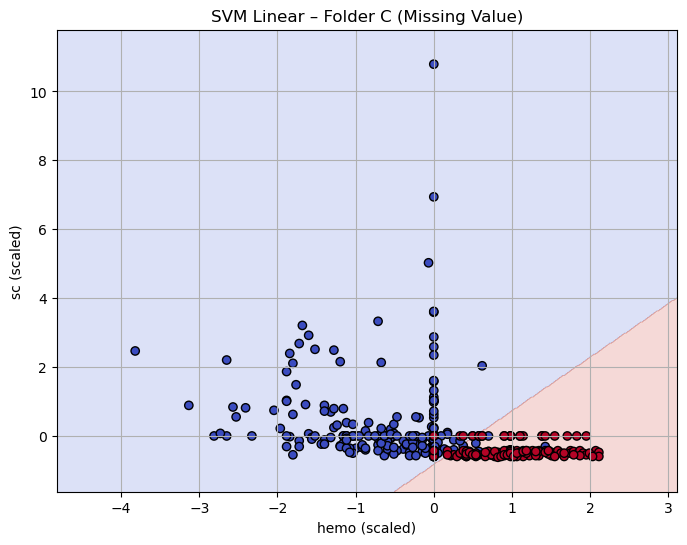

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import arff

# Load & preprocessing awal
with open('chronic_kidney_disease_full.arff') as f:
    data = arff.load(f)
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])
df_viz = df[['hemo', 'sc', 'class']].copy()
df_viz['class'] = df_viz['class'].map({'ckd': 0, 'notckd': 1})

# Simulasi missing value 15%
np.random.seed(42)
for col in ['hemo', 'sc']:
    missing_idx = np.random.choice(df_viz.index, size=int(len(df_viz)*0.15), replace=False)
    df_viz.loc[missing_idx, col] = np.nan

# Isi NaN dengan mean
df_viz['hemo'] = pd.to_numeric(df_viz['hemo'], errors='coerce').fillna(df_viz['hemo'].mean())
df_viz['sc'] = pd.to_numeric(df_viz['sc'], errors='coerce').fillna(df_viz['sc'].mean())

# Normalisasi dan training
X = df_viz[['hemo', 'sc']].values
y = df_viz['class'].values
X_scaled = StandardScaler().fit_transform(X)
model = SVC(kernel='linear').fit(X_scaled, y)

# Plot
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("SVM Linear – Folder C (Missing Value)")
plt.xlabel("hemo (scaled)")
plt.ylabel("sc (scaled)")
plt.grid(True)
plt.show()


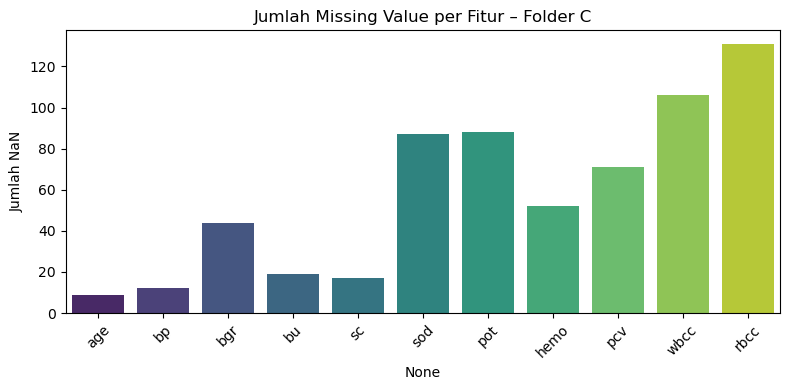

In [12]:
# Folder C – Bar chart jumlah missing value per fitur
numerics = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 
            'hemo', 'pcv', 'wbcc', 'rbcc']

missing = df[numerics].isna().sum()
missing = missing[missing > 0]  # hanya fitur yang punya missing

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.barplot(x=missing.index, y=missing.values, hue=missing.index, legend=False, palette="viridis")
plt.title("Jumlah Missing Value per Fitur – Folder C")
plt.ylabel("Jumlah NaN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


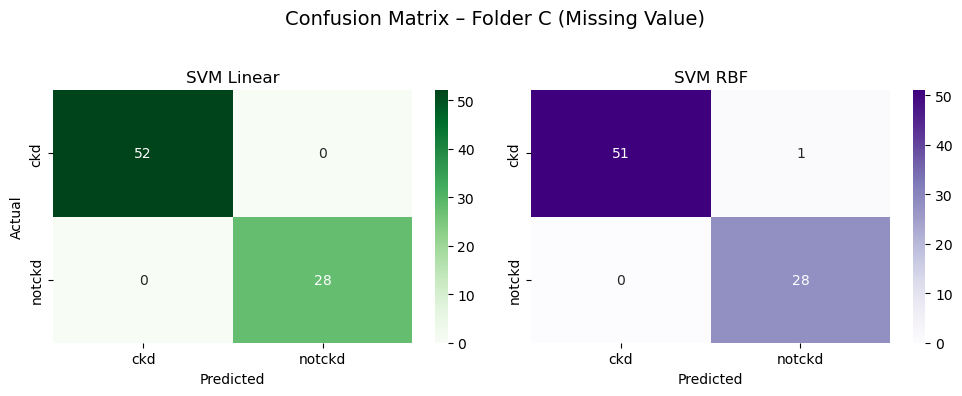

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix untuk Linear dan RBF
cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

# Buat figure berdampingan
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# SVM Linear
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Greens',
            xticklabels=['ckd', 'notckd'], yticklabels=['ckd', 'notckd'],
            ax=axes[0])
axes[0].set_title("SVM Linear")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# SVM RBF
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Purples',
            xticklabels=['ckd', 'notckd'], yticklabels=['ckd', 'notckd'],
            ax=axes[1])
axes[1].set_title("SVM RBF")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

# Tata letak
plt.suptitle("Confusion Matrix – Folder C (Missing Value)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
